#### Image Classification

In [274]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import torch.nn.functional as F

In [275]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = datasets.ImageFolder(root=r'C:\Users\there\Github_repo\TS_STA380\data\EuroSAT_RGB', transform=transform)

print(dataset.class_to_idx)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


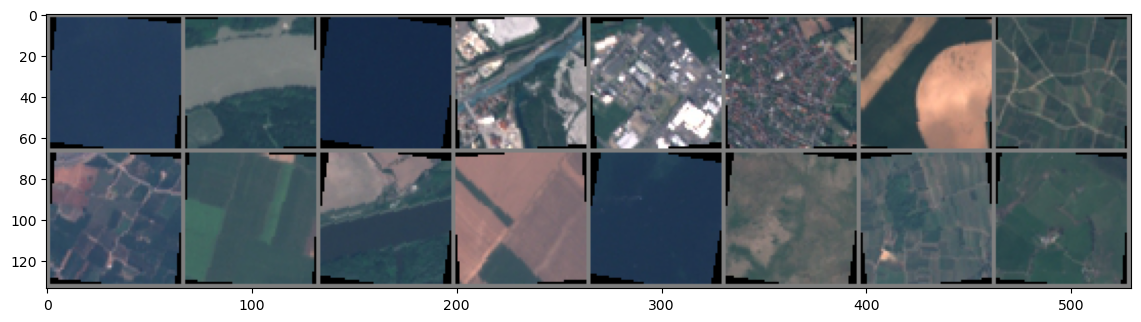

Labels: 9 8 9 3 4 7 0 6 6 0 8 0 9 2 6 5


In [276]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))

In [277]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 64, 64])


##### Base CNN

In [278]:
# Let's define a simple CNN to classify digits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 80, 4, 1)
        self.fc1 = nn.Linear(67280, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 80, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=67280, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [279]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [280]:
# Number of training epochs
num_epochs = 10

# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')


Epoch 1, Loss: 0.9827538713260934
Epoch 2, Loss: 0.6148610759664465
Epoch 3, Loss: 0.49756794618235695
Epoch 4, Loss: 0.42672227945592667
Epoch 5, Loss: 0.36093746739405175
Epoch 6, Loss: 0.30811390215048085
Epoch 7, Loss: 0.2804836019432103
Epoch 8, Loss: 0.24369901173644595
Epoch 9, Loss: 0.22846273466668748
Epoch 10, Loss: 0.22337506954592687
Finished Training


Accuracy: 0.88


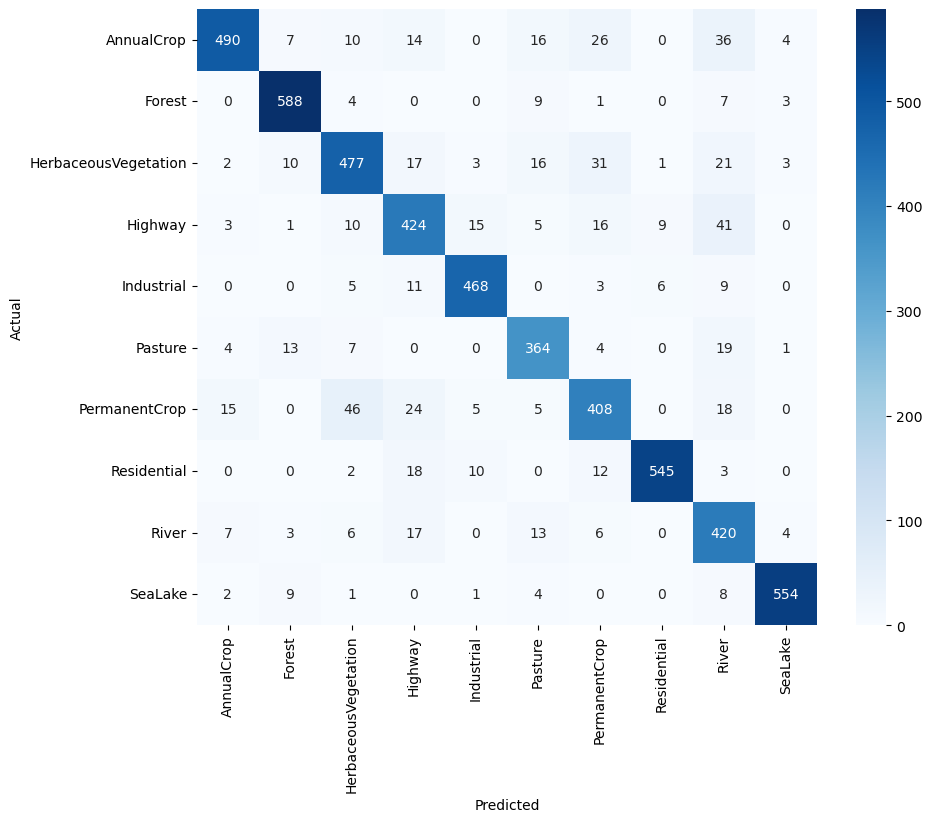

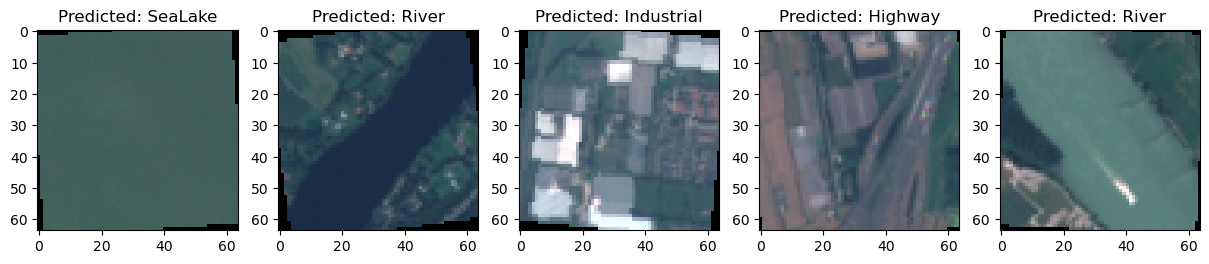

In [281]:
# Evaluation on the test set
net.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Show some predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(zip(images[:5], preds[:5])):
    axes[i].imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # unnormalize and show
    axes[i].set_title(f'Predicted: {dataset.classes[label]}')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


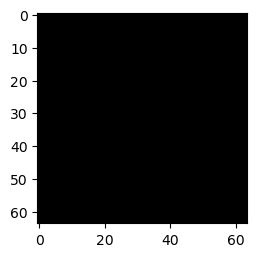

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: SeaLake, Actual: SeaLake


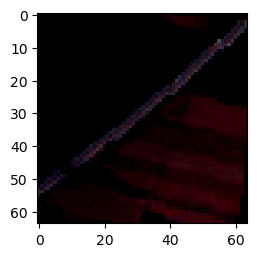

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Highway, Actual: Highway


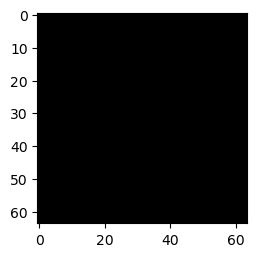

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Forest, Actual: AnnualCrop


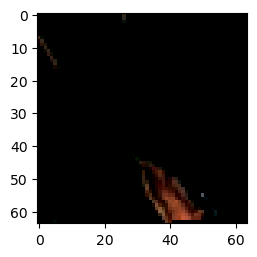

Predicted: River, Actual: River


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


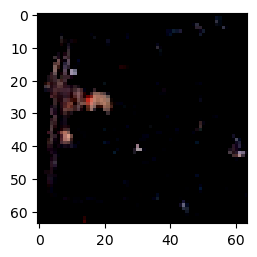

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Residential, Actual: Residential


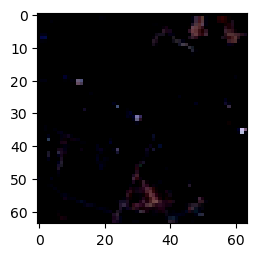

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: River, Actual: River


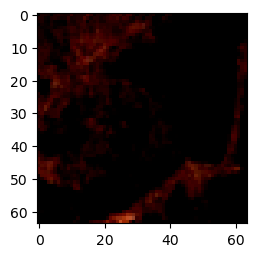

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: PermanentCrop, Actual: HerbaceousVegetation


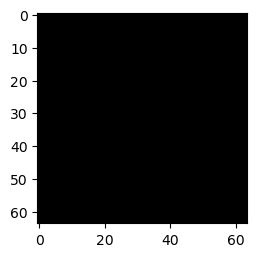

Predicted: SeaLake, Actual: SeaLake


In [282]:
# Show some test images with predictions
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of test data
inputs, classes = next(iter(test_loader))

# Make predictions
net.eval()
outputs = net(inputs)
_, preds = torch.max(outputs, 1)

# Display images with predictions
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    imshow(inputs[i])
    print(f"Predicted: {dataset.classes[preds[i]]}, Actual: {dataset.classes[classes[i]]}")
plt.show()


##### ResNet 18

c:\Users\there\anaconda3\envs\ml_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\there\anaconda3\envs\ml_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.94


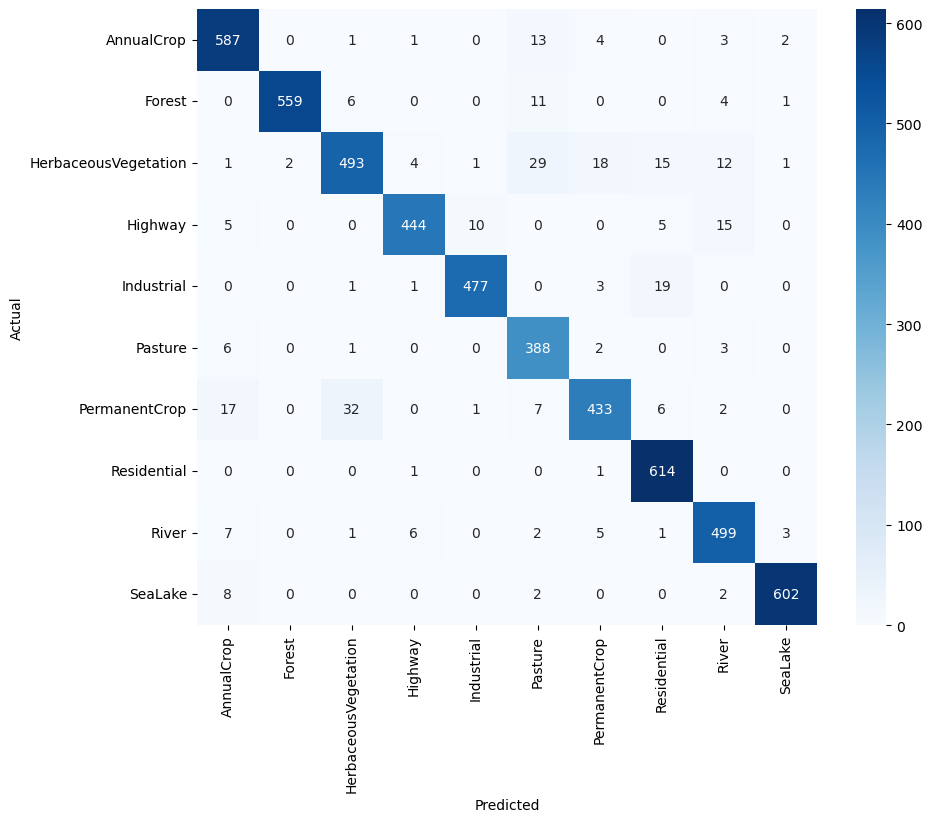

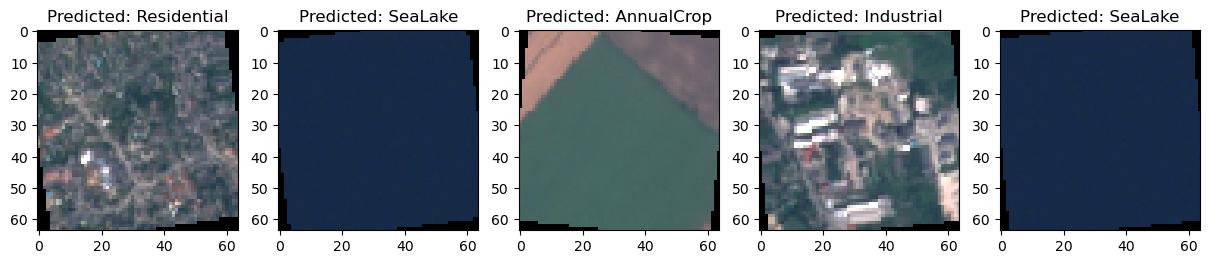

In [12]:
#This is a pre trained model of 18 convolutional layers existing in the pytorch module
model = models.resnet18(pretrained=True) #residual network
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))  # Adjust final layer for the number of classes

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
for epoch in range(10):  # example with 10 epochs
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Show some predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(zip(images[:5], preds[:5])):
    axes[i].imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # unnormalize and show
    axes[i].set_title(f'Predicted: {dataset.classes[label]}')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


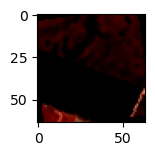

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AnnualCrop, Actual: AnnualCrop


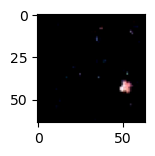

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Residential, Actual: Residential


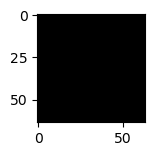

Predicted: SeaLake, Actual: SeaLake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


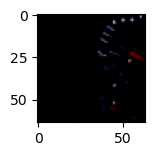

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Residential, Actual: Residential


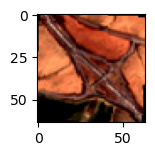

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Highway, Actual: Highway


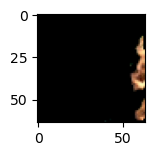

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: River, Actual: River


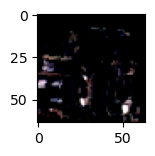

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Industrial, Actual: Industrial


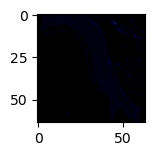

Predicted: Pasture, Actual: River


In [27]:
# Show some test images with predictions
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of test data
inputs, classes = next(iter(test_loader))

# Make predictions
model.eval()
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Display images with predictions
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    imshow(inputs[i])
    print(f"Predicted: {dataset.classes[preds[i]]}, Actual: {dataset.classes[classes[i]]}")
plt.show()


Model Comparison: Base CNN vs. ResNet Model
1. 
a. Architecture Overview:
Base CNN :
The Base CNN consists of two convolutional layers followed by two fully connected layers. The first convolutional layer takes a 3-channel input RGB image, and applies 32 filters of size 4x4, capturing basic features like edges or textures. The second convolutional layer builds on this by applying 80 filters of the same size to the output of the first layer, extracting more complex patterns. After the convolutional layers, the output is flattened into a vector of 67,280 features, which is then fed into the first fully connected layer, reducing it to 256 features. This intermediate layer allows the network to learn high-level representations of the data. Finally, the second fully connected layer reduces the features to 10 outputs, representing the predicted classes in a classification task. 
Complexity: This architecture is relatively simple but powerful enough to handle a range of image recognition tasks.

ResNet (Residual Network):
ResNet is a deep convolutional neural network (CNN) with multiple residual blocks. ResNet-18, for example, has 18 layers. Each residual block allows gradients to flow directly through the network, making it easier to train deeper networks.
Complexity: ResNet can capture more complex patterns due to its depth and the use of residual connections, making it highly effective for tasks like image classification.

b. Test-Set Accuracy:
Base CNN :
This model has a slightly lower accuracy due to its limited capacity to capture complex features. For the EuroSAT_RGB dataset, it has a 88% test accuracy.
ResNet Model:
ResNet models are known for their high accuracy on image classification tasks. The model was able to achieve 94% test accurac

2. Example Images from the Test Set with Predicted Classes
After visualizing test set images and their predicted classes from both Base CNN and ResNet 18 models the below is observed:

Base CNN : The model struggles with images that have complex features or overlapping categories, leading to misclassifications.
ResNet Model: The ResNet model accurately classifies most images, even those with challenging features.

3. Confusion Matrix
A confusion matrix provides insight into the performance of each model across different classes.

Base CNN :
The matrix shows a significant number of off-diagonal entries, indicating frequent misclassifications. Classes like AnnualCrop, Forest, Highway seem to have frequent misclassifications. The highest misclassification is for the class PermanentCrop where 46 images were misclassified as HerbaceousVegetation.

ResNet Model:
This matrix has more entries along the diagonal, indicating correct classifications. Off-diagonal entries are fewer. The highest misclassification is again for the class PermanentCrop where 32 images were misclassified as HerbaceousVegetation. The misclassified images dropped indicating that the ResNet model performs better for overlapping or complex images and is a better learner on average.